In [1]:
import numpy as np
from qibo import gates, hamiltonians, models
from scipy.optimize import minimize
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import argparse

[Qibo|WARNING|2021-03-29 12:36:40]: Custom operators not found, skipping custom operators load.
[Qibo|WARNING|2021-03-29 12:36:40]: Removing custom operators from available backends.
[Qibo|WARNING|2021-03-29 12:36:40]: Einsum will be used to apply gates with tensorflow.


In [2]:
def hamiltonian(nqubits):
        m0 = (1/nqubits)*hamiltonians.Z(nqubits, numpy=True).matrix
        ham = hamiltonians.Hamiltonian(nqubits, m0)
        return ham
    
def generator(params, x):
    circuit = models.Circuit(nqubits)
    circuit.add(gates.RY(0, params[0]*x + params[1]))
    circuit.add(gates.RY(1, params[2]*x + params[3]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[4]*x + params[5]))
    circuit.add(gates.RY(1, params[6]*x + params[7]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[8]*x + params[9]))
    circuit.add(gates.RY(1, params[10]*x + params[11]))
    return circuit
    
def cost_generator(params, opt_params_disc, samples, bins, count):
    cost = 0
    #run generator
    shots_fake = sample_generator(params, samples, bins)
    #run discriminator
    for i in range(len(mean_bins)):
        state = discriminator(opt_params_disc, mean_bins[i]).execute()
        probs = (1 - encoder.expectation(state).numpy().real)/2
        cost -= shots_fake[i]*probs
                
    if count[0] % 1 == 0:
        print(count[0], cost)
    count[0] += 1      
        
    return cost

def discriminator(params, x):
    circuit = models.Circuit(nqubits)
    circuit.add(gates.RY(0, params[0]*x + params[1]))
    circuit.add(gates.RY(1, params[2]*x + params[3]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[4]*x + params[5]))
    circuit.add(gates.RY(1, params[6]*x + params[7]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[8]*x + params[9]))
    circuit.add(gates.RY(1, params[10]*x + params[11]))
    return circuit
        
def cost_discriminator(params, opt_params_gen, shots_real, shots_fake, count):
    cost = 0
    for i in range(len(mean_bins)):
        #run real and fake data
        state = discriminator(params, mean_bins[i]).execute()
        probs = (1 - encoder.expectation(state).numpy().real)/2
        cost += (shots_fake[i]-shots_real[i])*probs
        
    if count[0] % 50 == 0:
        print(count[0], cost)
    count[0] += 1
        
    return cost

def sample_gaussian(mu, sigma, samples, bins):
    s = np.random.normal(mu, sigma, samples)
    count, bins, ignored = plt.hist(s, bins)
    return count

def sample_generator(params, samples, bins):
    fake_gaussian_sampling = []
    for i in range(samples):
        x = np.random.uniform(-1, 1)
        fake_sample = encoder.expectation(generator(params, x).execute()).numpy().real
        fake_gaussian_sampling.append(fake_sample)
    count, bins, ignored = plt.hist(fake_gaussian_sampling, bins)
    return count


In [3]:
nqubits = 2
encoder = hamiltonian(nqubits)
nparams_gen = 12
nparams_disc = 12
initial_params_disc = np.random.uniform(0, 2*np.pi, nparams_disc)
initial_params_gen = np.random.uniform(0, 2*np.pi, nparams_gen)

[  0.   1.   5.   9.  26.  66. 124. 181. 287. 324. 298. 251. 193. 134.
  60.  32.   8.   1.   0.   0.]


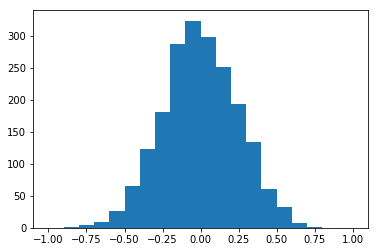

In [4]:
samples = 2000
bins = np.linspace(-1.0, 1.0, 21)
mean_bins = np.linspace(-0.95, 0.95, 20)
count_real = sample_gaussian(0, 0.25, samples, bins)
print(count_real)

[ 71.  92.  65.  48.  61.  63.  96. 194. 229. 222. 221. 387.  41.  53.
  59.  98.   0.   0.   0.   0.]


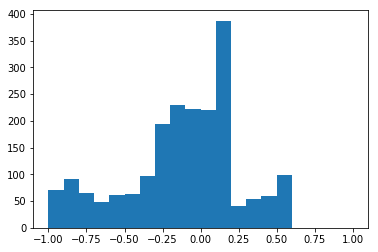

In [5]:
count_fake = sample_generator(initial_params_gen, samples, bins)
print(count_fake)


 Discriminator results: 
0 67.77292023660982
50 -151.13157080972724
100 -231.4487629754282
150 -265.2738340875795
200 -286.85101009907066
250 -298.003579632754
300 -299.8845717246205
350 -300.6482239827407
400 -302.7246372691653
450 -303.8804253911034
500 -308.4536317666073
550 -314.95339288561496
600 -318.7570758708524
650 -318.781895678849
700 -318.7824189556977
750 -318.78245519273474
800 -318.7824579415434
Final parameters:  [-2.68145157  3.16820277  0.01323349  1.64831394  4.83284663  4.86831745
  4.87265327 -1.26959642  5.02970023  2.05816818  2.97352366  3.63293936]
Final cost function:  -318.78245794153975

 Generator results: 


/home/carlos/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


0 -1342.0614540111933
1 -1337.6053667986014
2 -1219.4159653674494
3 -1412.17142438167
4 -1434.650813555044
5 -1434.4898772192796
6 -1436.1952210028319
7 -1417.5476997223818
8 -1454.7559670096541
9 -1506.9702036300034
10 -959.1998325619562
11 -1518.7247059544236
12 -1616.6326275897493
13 -1543.6909660860629
14 -1585.2814881792604
15 -1619.879997785798
16 -1584.0591060442828
17 -1605.2516627963885
18 -1623.7630827478663
19 -1619.5796466747524
20 -1612.0282106262814
21 -1610.1776279617839
22 -1705.3761049278203
23 -1591.0739649414156
24 -1711.692636683422
25 -1742.5930643294082
26 -1693.371758949542
27 -1733.77808103055
28 -1712.6229651935444
29 -1744.2420277490821
30 -1741.863691735999
31 -1755.045092452235
32 -1745.3310798974067
33 -1740.9527190366514
34 -1746.7927488767814
35 -1491.1052526613842
36 -1302.6013542862186
37 -1755.1731778605167
38 -1696.4377398465067
39 -1584.8675380321888
40 -1766.4318714054414
41 -1763.141991093755
42 -1745.6011749820916
43 -1746.2602262712214
44 -1755.7

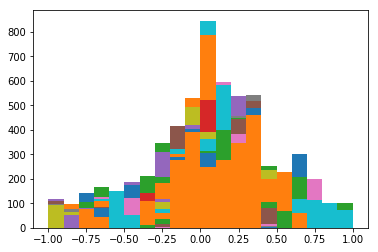

In [6]:
count = [0]
print('\n Discriminator results: ')
result_disc = minimize(lambda p: cost_discriminator(p, initial_params_gen, count_real, count_fake, count), initial_params_disc,
                          method='Powell', bounds=[0, 2*np.pi], options={'maxiter': 1e3, 'maxfev': 1e3})
print('Final parameters: ', result_disc.x)
print('Final cost function: ', result_disc.fun)

count = [0]
print('\n Generator results: ')
result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), initial_params_gen,
                          method='Powell', bounds=[0, 2*np.pi], options={'maxiter': 30, 'maxfev': 30})
print('Final parameters: ', result_gen.x)
print('Final cost function: ', result_gen.fun)

[  0.   0.   0.   0.   0.   0.   0.   0. 264. 392. 275. 279. 320. 468.
   2.   0.   0.   0.   0.   0.]


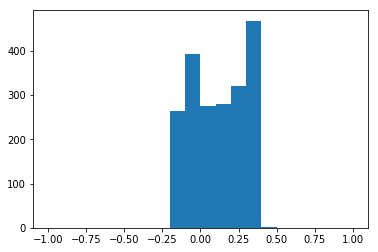

In [8]:
count_fake = sample_generator(result_gen.x, samples, bins)
print(count_fake)


 Discriminator results: 
0 200.05167517414407
50 -357.46559926373686
100 -392.2810658737868
150 -145.79662421170767
200 -415.1236059715867
250 -419.7485117731338
300 -269.52419439440825
350 -425.03349732281407
400 -363.21340363425077
450 -385.96765709720256
500 -389.1944130039314
550 -401.0430964375053
600 -428.05102773433174
650 -428.07800870293073
700 -428.1935190929465
750 -428.22118172574784
800 -428.26900104941967
850 -428.53447183109677
900 -428.564868833137
950 -412.8800635088931
Final parameters:  [ 1.69653234  4.44940044  5.3541546   2.78755647  4.19565202  4.9616659
  4.18965663 -1.30262189  5.38276295  2.76797059  1.68061399  4.45996604]
Final cost function:  -428.58182734930995

 Generator results: 
0 -804.9988809871851
1 -797.0018346409468
2 -897.1937195460298
3 -1319.3036666967876
4 -1405.1622951362287
5 -1420.6347000199373
6 -1418.1921924650485
7 -1373.6463940865126
8 -1454.7986869547335
9 -1411.624706501314
10 -1435.786370859907
11 -1429.3450541049647
12 -1444.56422125

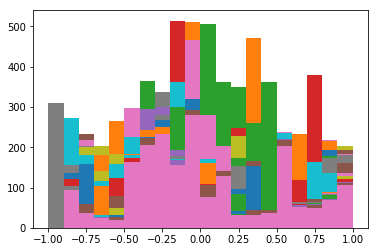

In [9]:
count = [0]
print('\n Discriminator results: ')
result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                          method='Powell', bounds=[0, 2*np.pi], options={'maxiter': 1e3, 'maxfev': 1e3})
print('Final parameters: ', result_disc.x)
print('Final cost function: ', result_disc.fun)

count = [0]
print('\n Generator results: ')
result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                          method='Powell', bounds=[0, 2*np.pi], options={'maxiter': 30, 'maxfev': 30})
print('Final parameters: ', result_gen.x)
print('Final cost function: ', result_gen.fun)

[  0.  78.  45.  23.  24. 184. 217. 216. 151. 250.  93. 115.  23.  33.
  39. 207.  63.  56.  68. 115.]


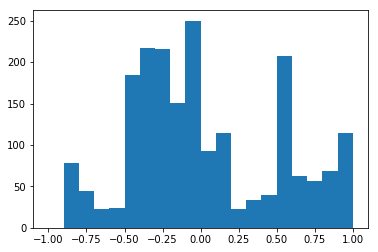

In [10]:
count_fake = sample_generator(result_gen.x, samples, bins)
print(count_fake)